# Cats vs Dogs - Image Classification with Convolutional Neural Networks

In [1]:
import numpy as np
import tensorflow
import keras
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, Dropout, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.utils import layer_utils
from keras.initializers import glorot_uniform
import scipy.misc
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline


Using TensorFlow backend.


## Data pre-processing and data augmentation

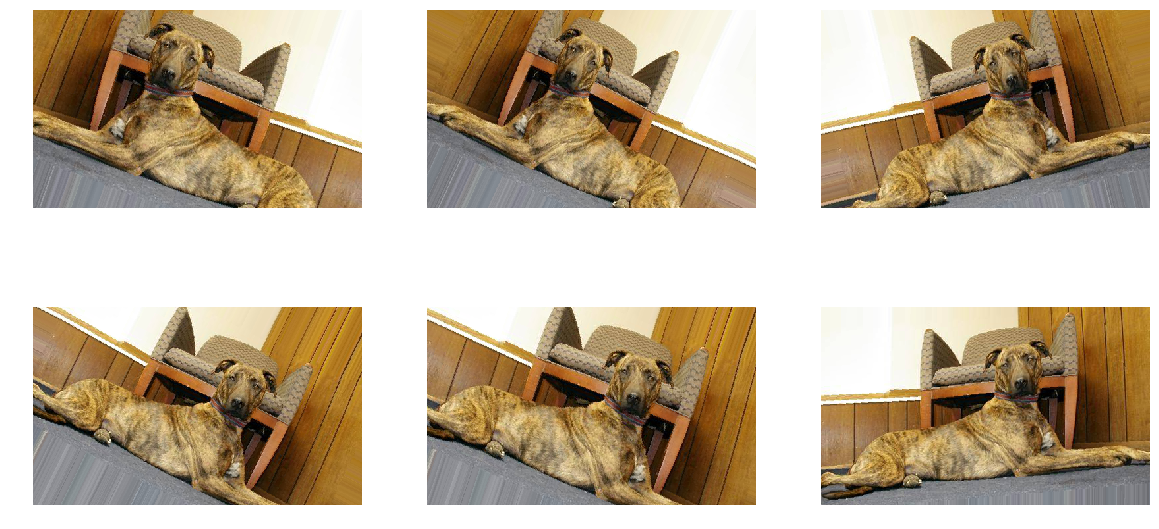

In [2]:
# Let's see what our image generator actually do.

plt.figure(figsize=(20,10))

datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        rotation_range=40)


img = load_img('data/train/dogs/dog.1749.jpg')  
x = img_to_array(img) 
x = x.reshape((1,) + x.shape)  

i = 0
for batch in datagen.flow(x, batch_size=1):
    i += 1
    plt.subplot(2,3,i)
    plt.imshow(array_to_img(batch[0,]))
    plt.axis('off')
    if i >= 6:
        break  

In [3]:
batch_size = 16

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        rotation_range=20)


val_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
train_generator = train_datagen.flow_from_directory(
        'data/train',  
        target_size=(150, 150),  
        batch_size=batch_size,
        class_mode='binary') 

validation_generator = val_datagen.flow_from_directory(
        'data/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


## Model 1 - Training small convnet with 3 convolutional layers from strach : 90 % accuracy

In [5]:
from keras.models import Sequential

def model1():
    
    model1 = Sequential()

    model1.add(Conv2D(16, (5,5), input_shape=(150,150,3), padding = 'same', strides = (2,2)))
    model1.add(BatchNormalization(axis = 3))
    model1.add(Activation('relu'))
    model1.add(MaxPooling2D(pool_size=(4,4)))

    model1.add(Conv2D(32, (3,3), padding = 'same'))
    model1.add(BatchNormalization(axis = 3))
    model1.add(Activation('relu'))
    model1.add(MaxPooling2D(pool_size=(2,2)))
    model1.add(Dropout(0.1))

    model1.add(Conv2D(64, (3,3), padding = 'same'))
    model1.add(BatchNormalization(axis = 3))
    model1.add(Activation('relu'))
    model1.add(MaxPooling2D(pool_size=(2,2)))

    model1.add(Flatten())
    model1.add(Dense(30))
    model1.add(Activation('relu'))
    model1.add(Dropout(0.1))
    model1.add(Dense(1))
    model1.add(Activation('sigmoid'))
    
    return model1


In [6]:
model1 = model1()

model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model1.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 75, 75, 16)        1216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 75, 75, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 32)        4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 18, 18, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 18, 18, 32)        0         
__________

In [7]:
history1 = model1.fit_generator(
        train_generator,
        steps_per_epoch=22500 // batch_size,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=2500 // batch_size)

Epoch 1/30
1406/1406 [==============================] - 215s 153ms/step - loss: 0.5926 - acc: 0.6732 - val_loss: 0.7700 - val_acc: 0.5633
Epoch 2/30
1406/1406 [==============================] - 216s 153ms/step - loss: 0.4967 - acc: 0.7608 - val_loss: 0.4209 - val_acc: 0.8093
Epoch 3/30
1406/1406 [==============================] - 202s 144ms/step - loss: 0.4421 - acc: 0.7977 - val_loss: 0.4699 - val_acc: 0.7724
Epoch 4/30
1406/1406 [==============================] - 202s 144ms/step - loss: 0.4100 - acc: 0.8172 - val_loss: 0.5001 - val_acc: 0.7151
Epoch 5/30
1406/1406 [==============================] - 206s 147ms/step - loss: 0.3900 - acc: 0.8245 - val_loss: 0.3190 - val_acc: 0.8630
Epoch 6/30
1406/1406 [==============================] - 202s 144ms/step - loss: 0.3647 - acc: 0.8390 - val_loss: 0.3128 - val_acc: 0.8718
Epoch 7/30
1406/1406 [==============================] - 202s 144ms/step - loss: 0.3482 - acc: 0.8458 - val_loss: 0.3404 - val_acc: 0.8534
Epoch 8/30
1406/1406 [============

In [8]:
model1.save('C_D_model1.h5')

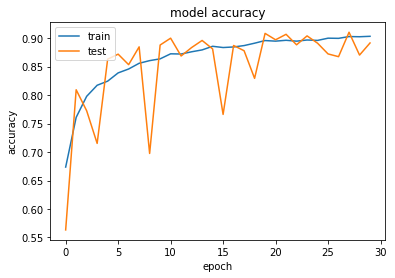

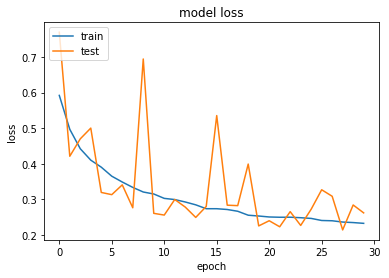

In [21]:
def plot_training(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

plot_training(history1)

## Model 2 - Convnet with 5 convolutional layers : 93.75 % accuracy

In [10]:
def model2():
    
    model = Sequential()
    
    model.add(Conv2D(32, (7, 7), input_shape=(150, 150, 3), padding = 'same',strides = (2,2)))
    model.add(BatchNormalization(axis = 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (5, 5), padding = 'same'))
    model.add(BatchNormalization(axis = 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3),padding = 'same'))
    model.add(BatchNormalization(axis = 3))
    model.add(Activation('relu'))

    model.add(Conv2D(128, (3, 3),padding = 'same'))
    model.add(BatchNormalization(axis = 3))
    model.add(Activation('relu'))

    model.add(Conv2D(64, (3, 3),padding = 'same'))
    model.add(BatchNormalization(axis = 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten()) 
    model.add(Dense(60))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    return model



In [11]:
model2 = model2()

model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 75, 75, 32)        4736      
_________________________________________________________________
batch_normalization_4 (Batch (None, 75, 75, 32)        128       
_________________________________________________________________
activation_6 (Activation)    (None, 75, 75, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 64)        51264     
_________________________________________________________________
batch_normalization_5 (Batch (None, 37, 37, 64)        256       
_________________________________________________________________
activation_7 (Activation)    (None, 37, 37, 64)        0         
__________

In [12]:
history2 = model2.fit_generator(
        train_generator,
        steps_per_epoch=22500 // batch_size,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=2500 // batch_size)

Epoch 1/30
1406/1406 [==============================] - 578s 411ms/step - loss: 0.6687 - acc: 0.5935 - val_loss: 0.9601 - val_acc: 0.5349
Epoch 2/30
1406/1406 [==============================] - 232s 165ms/step - loss: 0.6183 - acc: 0.6573 - val_loss: 0.5621 - val_acc: 0.7420
Epoch 3/30
1406/1406 [==============================] - 231s 165ms/step - loss: 0.5934 - acc: 0.6843 - val_loss: 0.5994 - val_acc: 0.6847
Epoch 4/30
1406/1406 [==============================] - 231s 164ms/step - loss: 0.5721 - acc: 0.7065 - val_loss: 0.5673 - val_acc: 0.7155
Epoch 5/30
1406/1406 [==============================] - 235s 167ms/step - loss: 0.5491 - acc: 0.7262 - val_loss: 0.5838 - val_acc: 0.6919
Epoch 6/30
1406/1406 [==============================] - 232s 165ms/step - loss: 0.5282 - acc: 0.7441 - val_loss: 0.5578 - val_acc: 0.7175
Epoch 7/30
1406/1406 [==============================] - 232s 165ms/step - loss: 0.5032 - acc: 0.7620 - val_loss: 0.4124 - val_acc: 0.8458
Epoch 8/30
1406/1406 [============

In [13]:
model2.save('C_D_model2.h5')

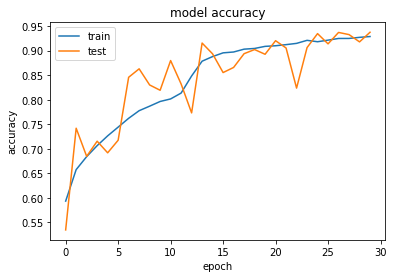

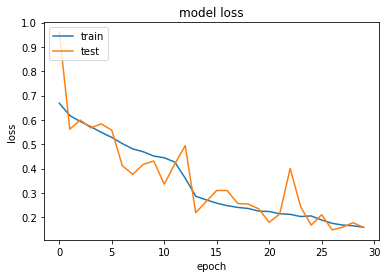

In [22]:
plot_training(history2)

## Model 3 - InceptionV3 model with weights pre-trained on ImageNet - 98 % accuracy

    

    Keras has deep learning models that are available with pre-trained weights. I will use inceptionV3 model with weights pre-trained on ImageNet. There are a lot of ways to use transfer learning for image classification task like freeze all layer and change softmax layer with specific to our problem and train only parameters that belongs to this softmax layer or freeze all layers but not last few layers and use these last few layers' weights as initialization change softmax layer with specific to our problem and train these last layers and softmax layer. However, in model3, I will take InceptionV3 model that pretrained on imagenet and I will change output layer and use all layers as initialization and then train the whole network.

In [15]:
model3 = keras.applications.InceptionV3(include_top=False, input_shape=(150, 150, 3),
                                          weights='imagenet')

new_output = keras.layers.GlobalAveragePooling2D()(model3.output)

new_output = keras.layers.Dense(1, activation='sigmoid')(new_output)

model3 = keras.engine.training.Model(model3.inputs, new_output)

model3.compile(
    loss='binary_crossentropy',  
    optimizer=keras.optimizers.adamax(lr=1e-4),  
    metrics=['accuracy']  
)


In [16]:
model3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 74, 74, 32)   96          conv2d_9[0][0]                   
__________________________________________________________________________________________________
activation_13 (Activation)      (None, 74, 74, 32)   0           batch_normalization_9[0][0]      
__________________________________________________________________________________________________
conv2d_10 

In [18]:
history3 = model3.fit_generator(
        train_generator,
        steps_per_epoch=22500 // batch_size,
        epochs=5,#5 or 4
        validation_data=validation_generator,
        validation_steps=2500 // batch_size)

Epoch 1/5
1406/1406 [==============================] - 1735s 1s/step - loss: 0.1907 - acc: 0.9218 - val_loss: 0.0806 - val_acc: 0.9683
Epoch 2/5
1406/1406 [==============================] - 1735s 1s/step - loss: 0.1150 - acc: 0.9566 - val_loss: 0.0614 - val_acc: 0.9752
Epoch 3/5
1406/1406 [==============================] - 1737s 1s/step - loss: 0.0780 - acc: 0.9704 - val_loss: 0.0548 - val_acc: 0.9796
Epoch 4/5
1406/1406 [==============================] - 1735s 1s/step - loss: 0.0621 - acc: 0.9784 - val_loss: 0.0477 - val_acc: 0.9800
Epoch 5/5
1406/1406 [==============================] - 1736s 1s/step - loss: 0.0481 - acc: 0.9823 - val_loss: 0.0484 - val_acc: 0.9800


In [19]:
model3.save('C_D_model3.h5')

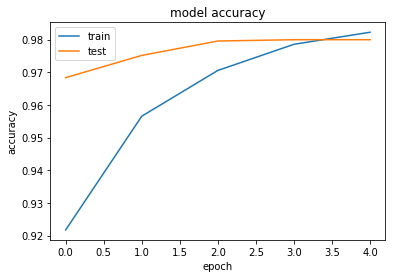

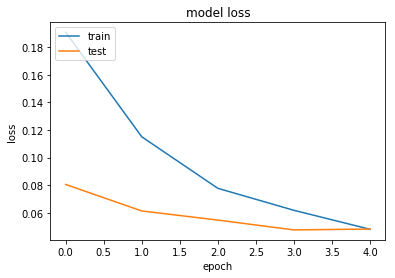

In [23]:
plot_training(history3)

## Model 4 - Another approach that use InceptionV3 model

    I won't train model4 here but I want to show another approach that can be used with pretrained models. First, we can change output layer that is specific to our problem also before that output layer, we can add a dense layer. After that we can freeze all layer but not newly added dense layer and new output layer and train them with big learning rate. Lastly, we can freeze first 250 layers and train other part of the network with a small learning rate. The aim of the training newly added dense and output layer first is that not losing learned things in frozen part of the pretrained model quickly with using big learning rate.

In [ ]:
base_model = keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

x = base_model.output

x = keras.layers.GlobalAveragePooling2D()(x)

x = Dense(128, activation='relu')(x)

predictions = Dense(1, activation='sigmoid')(x)

model4 = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model4.summary()

In [ ]:
model4.compile(
    loss='binary_crossentropy',  
    optimizer=keras.optimizers.adamax(lr=1e-2),  # we can take big lr here because we fixed first layers
    metrics=['accuracy']  
)

In [ ]:
model4.fit_generator(
        train_generator,
        steps_per_epoch=22500 // batch_size,
        epochs=5,
        validation_data=validation_generator,
        validation_steps=2500 // batch_size)

In [ ]:
for layer in model4.layers[:249]:
   layer.trainable = False
for layer in model4.layers[249:]:
   layer.trainable = True

model4.compile(optimizer=keras.optimizers.adamax(lr=1e-4), loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
model4.fit_generator(
        train_generator,
        steps_per_epoc=22500 // batch_size,
        epochs=7,
        validation_data=validation_generator,
        validation_steps=2500 // batch_size)

In [ ]:
model4.save('C_D_model4.h5')

In [ ]:
plot_training(history4)

## Some Examples

    Is there a dog in the picture ? What is the probability of that ? In this part, we will see what our models predict and with what probability ?

In [24]:
def prob_plot(prediction):
    
    axes = plt.gca()
    axes.set_ylim([0,1.01])
    
    predictions = [1-prediction[0][0],prediction[0][0]]
    
    plt.bar([0,1], predictions, align='center', alpha=0.5)
    plt.xticks([0,1], ('Cat', 'Dog'))
    plt.ylabel('Probability')
 
    plt.show()

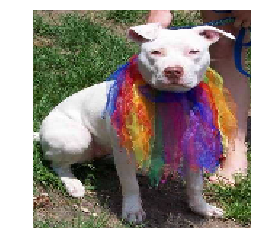

In [25]:
img = load_img('data/validation/dogs/dog.220.jpg') 
img = img.resize((150,150))

plt.axis('off')
plt.imshow(img)

In [26]:
img_a = img_to_array(img) 
img_a = img_a.reshape((1,) + img_a.shape)  

img_a = img_a /255.

0.999713


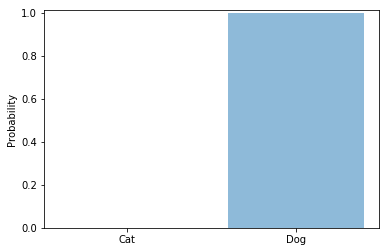

In [27]:
prediction = model1.predict(img_a) 
print(prediction[0][0])
prob_plot(prediction)

0.997865


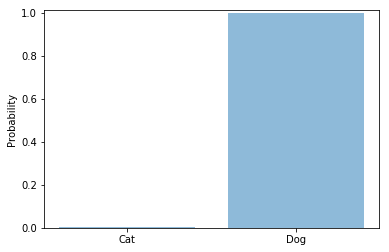

In [28]:
prediction = model2.predict(img_a) 
print(prediction[0][0])
prob_plot(prediction)

0.999975


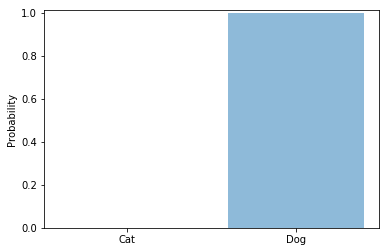

In [29]:
prediction = model3.predict(img_a) 
print(prediction[0][0])
prob_plot(prediction)

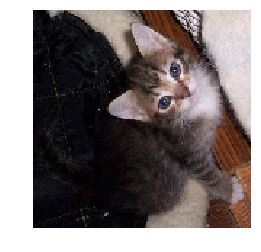

In [30]:
img = load_img('data/validation/cats/cat.225.jpg') 
img = img.resize((150,150))

plt.axis('off')
plt.imshow(img)

In [31]:
img_a = img_to_array(img) 
img_a = img_a.reshape((1,) + img_a.shape)  

img_a = img_a /255.

0.0860589


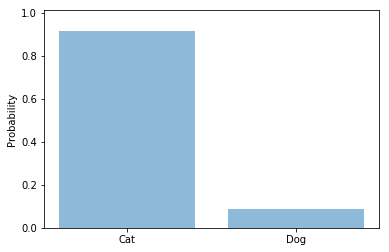

In [32]:
prediction = model1.predict(img_a) 
print(prediction[0][0])
prob_plot(prediction)

0.000488857


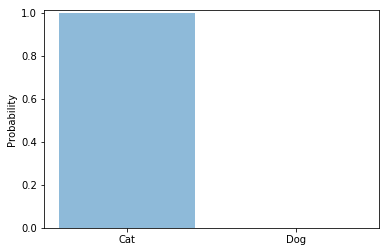

In [33]:
prediction = model2.predict(img_a) 
print(prediction[0][0])
prob_plot(prediction)

0.0050849


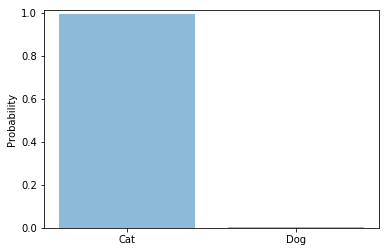

In [34]:
prediction = model3.predict(img_a) 
print(prediction[0][0])
prob_plot(prediction)